## Description of algorithm

**In a nutshell:**

We use the same algo as here [doi:10.1038/nphys1781](https://www.nature.com/articles/nphys1781), but instead of subtracting one pure separable state at time, we subtract biseparable mixtures. 
Instead of searching for maximum by partial eigenprojections, we utilize generalized Bloch angle parameterization.
The challenge is to find the mixture to be subtracted, but here we use prior information about components which we prepare and find find the constituents in the mixture by biasing the current matrix toward the theoretical components. This is the key modification because if we would subtract just pure separable states, it would actually increase purity of the remainder, violating one of the requirements of the original algorithm.

**Inputs:**

* Density matrix $\rho_0$ to be tested
* Maximum number of iterations permitted
* (implicit) List of theoretical pure separable states
* (implicit) List of possible partitions of the components

**Procedure:**
- 1 - find maximally overlapping biseparable mixture $\eta=\sum\limits_{j}^{8} |\psi_{j}\rangle\langle\psi_{j}|w_j$
    - 1.1 - for each theoretical constituent term, make a biased version of $\rho_i$, i.e.
    $$
    \tilde{\rho}_{ij} = b\rho_i + (1-b)|\psi_{j}\rangle\langle\psi_{j}|,
    $$
    where theoretical state $|\psi_{j}\rangle$ is separable with some bipartition $k$.
    - 1.2. - for each biased density matrix, find maximally overlapping pure state $|\tilde{\psi_{j}} \rangle $, separable with some bipartition $k$ by maximization
    $$
    \max |\langle\tilde{\psi}_{j}| \tilde{\rho}_{ij} |\tilde{\psi}_{j}\rangle|
    $$
    over $|\tilde{\psi}_{j}\rangle$, this is done using generalized Bloch angles.
    - 1.3. optimize weight $w_j$ of mixture to maximize overlap with $\rho_i$.

- 2 - subtract $\epsilon_o \eta$ from $\rho_i$ to minimize purity of the trace-normalized remainder, 
$$
\epsilon_o = \argmin_\epsilon \mathrm{Tr}\left[\left(\frac{\rho_i - \epsilon\eta}{\mathrm{Tr}[\rho_i - \epsilon\eta]}\right)^2\right]
$$
- 3 - assign the normalized remainder to $\rho_{i+1}$, 
$$
\rho_{i+1} := \left(\frac{\rho_i - \epsilon_o \eta}{\mathrm{Tr}[\rho_i - \epsilon_o \eta]}\right)
$$
- 4 - if purity of $rho_{i+1}$ is below threshold 1/7, then stop iteration and yield that state was biseparable, otherwise go to point 1. If number of iteration exceeds limit, stop iteration and state inconclusive result.



In [1]:
import itertools
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import minimize
import departed
from bisep_checker import (
    check_bisep,
    partitions,
    EPSILON,
    dagger,
    ketbra,
    kron,
    theo_rhos_3q,
    BinKet,
    HLO,
    HHI,
    LO,
    HI,
    CLO,
    CHI,
    purity,
)


def psd_projection(r: np.ndarray) -> np.ndarray:
    # force Hermiteanity
    hr = (r + r.T.conj()) * 0.5
    # do spectral decomposition
    evals, evecs = np.linalg.eigh(hr)
    # clip negative eigenvalues, 1e-16 is numerical epsilon
    devals = np.diag(np.clip(evals.real, 1e-16, None))
    # project to PSD matrix
    rp = evecs @ devals @ evecs.T.conj()
    # renorm and return
    return rp / np.trace(rp.real)


# load lin-inv reconstructed single-copy constituent states
# Load lin-inv reconstructed single-copy constituent states as a single numpy array
with h5py.File("data/new_single_copy_states.h5") as h5f:
    print(h5f.attrs.get("keys"))
    state_order = list(h5f.attrs.get("keys", []))
    rhos_single_copy_024 = np.array(h5f["rhos024"])
    rhos_single_copy_531 = np.array(h5f["rhos531"])
rhos_single_copy_024 = np.array([psd_projection(_r) for _r in rhos_single_copy_024])
rhos_single_copy_531 = np.array([psd_projection(_r) for _r in rhos_single_copy_531])

['a1' 'a2' 'a3' 'a4' 'b1' 'b2' 'b3' 'b4']


In [2]:
# check PPT
def ppt(rho, pt : partitions):
    if pt == partitions.A_BC:
        mask1 = [1,0,0]
    elif pt == partitions.AC_B:
        mask1 = [0,1,0]
    elif pt == partitions.AB_C:
        mask1 = [0,0,1]        
    else:
        print("Ooops!")
        raise
    
    rhopt = departed.ptranspose(rho, [2]*3, mask1)
    mineig = np.min(np.linalg.eigvalsh(rhopt))
    return mineig

In [3]:
q = 0.06
wghts = [(1-q)/8]*8 + [q/2]*2
rho_exp_024 = sum([w*r for r, w in zip(rhos_single_copy_024, wghts)])
rho_exp_531 = sum([w*r for r, w in zip(rhos_single_copy_531, wghts)])
rho_theo = sum([w*theo_rhos_3q[key] for key, w in zip(theo_rhos_3q, wghts)])

In [4]:
#helpers

def get_ra(rho):
    return departed.ptrace(rho, [2]*3, [0,1,1])

def get_rbc(rho):
    return departed.ptrace(rho, [2]*3, [1,0,0])

def pme(rho):
    mineig = np.linalg.eigvalsh(rho)
    print("Eigvalsh:")
    for e in mineig:
        print(f'{e:.2e}')
    print("---")

def mix(rho, q):
    return q*rho + (1-q)*np.eye(8)/8

def mas(rho):
    plt.matshow(np.abs(rho))
    plt.colorbar()
    plt.show()

def mris(rho):
    mos = np.hstack([rho.real, rho.imag])
    plt.matshow(mos)
    plt.colorbar()
    plt.show()

PPT: A_BC ... -0.09447940067644627
PPT: AB_C ... -0.17088984258845694
PPT: AC_B ... -0.09524914845498098
Eigvalsh:
1.02e-02
3.58e-02
4.13e-02
9.45e-02
1.05e-01
1.32e-01
1.44e-01
4.37e-01
---


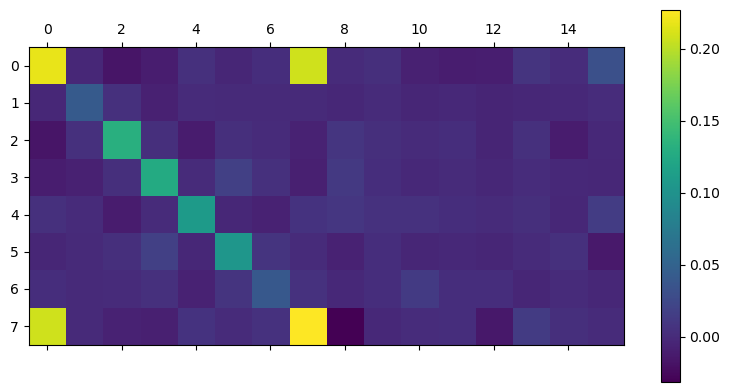

36: P=1.434e-01, F=1.612e-01, eps=2.512e-02
Finished in round 36
0.1423282170078073 0.14285714285714285


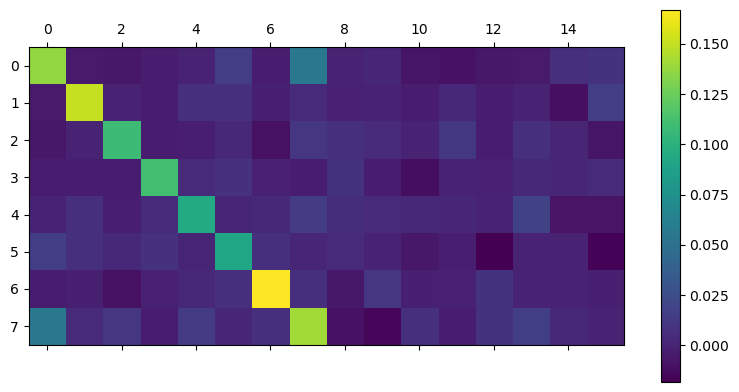

In [7]:
pmix = 0
rho_tested = rho_exp_024*(1-pmix) + pmix*np.eye(8)/8

for pt in partitions:
    print('PPT:', pt.name, '...', ppt(rho_tested, pt))
pme(rho_tested)
mris(rho_tested)
_, _, rmd, _ = check_bisep(rho_tested, 500)

print(purity(rmd/np.trace(rmd)), 1/7)
mris(rmd)


PPT: A_BC ... -0.10322233077691559
PPT: AB_C ... -0.17670614216899902
PPT: AC_B ... -0.09423111769648211
Eigvalsh:
6.29e-03
3.63e-02
4.08e-02
1.07e-01
1.16e-01
1.21e-01
1.31e-01
4.41e-01
---


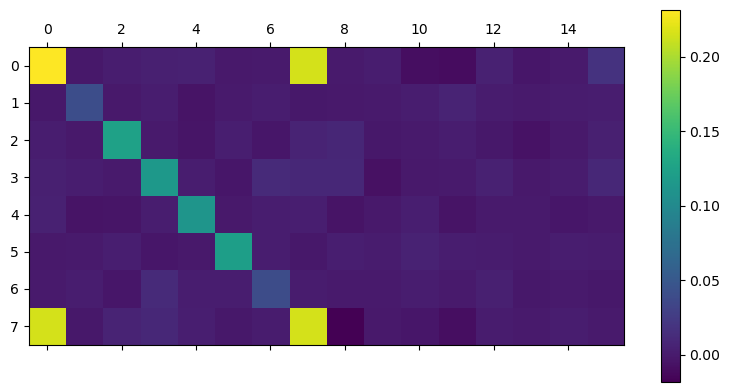

KeyboardInterrupt: 

In [6]:
pmix = 0
rho_tested = rho_exp_531*(1-pmix) + pmix*np.eye(8)/8
for pt in partitions:
    print('PPT:', pt.name, '...', ppt(rho_tested, pt))
pme(rho_tested)
mris(rho_tested)

_, _, rmd, _ = check_bisep(rho_tested, 500)
print(purity(rmd/np.trace(rmd)), 1/7)

mris(rmd)
